## CIM 10 classifier for Clef 2018 eHealth Task 1
Analysis of French biomedical text with the extraction of causes of death from a corpus of death reports in French 

Task description : [CLEF 2018 eHealth 2018](https://sites.google.com/view/clef-ehealth-2018/task-1-multilingual-information-extraction-icd10-coding?authuser=0)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import os
import keras
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import csv

In [8]:
%load_ext autoreload
%autoreload 2

rev_vocabulary = ['_PAD']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing texts


A dictionarie (thesaurus) has been made from avaliable corpus (cf notebook Dictionaries) : ICD 10 index, Snomed CT French version, Orphanet, CépiDC dictionnaries.

Text preprocessing is mainly using this thesaurus to deal with :
- correction of spelling errors
- compound words
- tokenization

Training texts has been prepared previously (see notebook Preprocessing clef texts)

ICD code reference is as sugested in the task description was taken from :
https://www.bfs.admin.ch/bfs/fr/home/statistiques/sante/nomenclatures/medkk/instruments-codage-medical.html#par_headline_782102000
 

In [144]:
from utils_ import *
from FeatureExtractor import *
fe=FeatureExtractor()
tp=fe.text_preprocessing

In [145]:
###CIM

codes=[]

with open('dictionaries/LIBCIM10MULTI.TXT', 'r', encoding="latin1") as f:
        
        next(f)
        
        for line in f:
            line_=line.split('|')
            c=line_[0].replace(' ','')
            type_=line_[1]
            if type_!='3':
                codes.append(c)


#icd=['UNK']+codes
icd=codes

In [146]:
len(icd)

38179

Import of reference vocabularies and preparation index that will be use for word/ICD code index.

In [147]:
th_base_sentences=[]
th_codes=[]
th_source=[]
index=[]
c_index=[]
with open('dictionaries/clef2018_thesaurus.csv', 'r', encoding="utf-8") as f:
    for line in f:
        line_=line.split(';')
        
        c=line_[1]
        o=line_[2].replace('\n','')
        if len(c)>0 :# and o in ['index CIM','Snomed','Orphanet','CIM']:
            c_=re.split(',',c)
            for co in c_:
                if co in icd:
                    index.append(line_[0])
                    c_index.append(co)
            th_codes.append(c_)
            th_source.append(line_[2])  
            th_base_sentences.append(line_[0])

### Build vocabulary and prepare feature extraction
FeatureExtraction class is fitted on the knowledge base and will use this vocabulary to produce words vectors for each sentence in the corpus that will be use for classification

In [148]:
fe.fit(th_base_sentences,START_VOCAB=['_PAD'])

### Load data that have been prepared

In [14]:
prep_sentences=[]
prep_codes=[]

with open('corpus/clef2018_FinalTrain.csv', 'r', encoding="utf-8") as f:
    for line in f:
        if len(line)>3:
            line_=line.split(';')
            s=re.split(r'\s', line_[0].replace('\n',''))
            s=[w for w in s if w in fe.dictionary]
            prep_sentences.append(s)
            c=re.split(r'\s',line_[1].replace('\n',''))
            if len(c[0])==0:
                c=[]
            prep_codes.append(c)
            id_=line_[2].replace('\n','')


In [15]:
all_codes=[c_ for c in prep_codes for c_ in c]

In [16]:
print('Total number of documents = '+str(len(prep_sentences)))
print('Total number of codes = '+str(len(all_codes)))

Total number of documents = 304021
Total number of codes = 379802


## Description of the data

### Distribtion of the ICD codes

In [17]:
counter_all_codes = Counter(all_codes)

In [18]:
len(counter_all_codes)

3259

In [19]:
n_total_codes=sum(counter_all_codes.values())
n_total_distinct_codes=len(counter_all_codes)
n_1000_distinct=len([n for n in counter_all_codes.values() if n>=1000])
n_1000_total=sum([n for n in counter_all_codes.values() if n>=1000])
n_200_1000_distinct=len([n for n in counter_all_codes.values() if n>=200 and n<1000])
n_200_1000_total=sum([n for n in counter_all_codes.values() if n>=200 and n<1000])
n_200_distinct=len([n for n in counter_all_codes.values() if n<200])
n_200_total=sum([n for n in counter_all_codes.values() if n<200])

In [20]:
print('Number of distinct codes = '+str(n_total_distinct_codes)+'\n'+
    '\nNb of distinct codes > 1000 occurences = '+str(n_1000_distinct)
      +' - total of occurences = '+str(n_1000_total)+' ('+str(round(n_1000_total*100/n_total_codes,1))+'%)'
      '  \nNb of distinct codes 200-1000 occurences = '+str(n_200_1000_distinct)
      +' - total of occurences = '+str(n_200_1000_total)+' ('+str(round(n_200_1000_total*100/n_total_codes,1))+'%)'
     +'  \nNb of distinct codes <200 occurences = ' +str(n_200_distinct)
      +' - total of occurences = '+str(n_200_total)+' ('+str(round(n_200_total*100/n_total_codes,1))+'%)' 
     )

Number of distinct codes = 3259

Nb of distinct codes > 1000 occurences = 72 - total of occurences = 240301 (63.3%)  
Nb of distinct codes 200-1000 occurences = 180 - total of occurences = 80316 (21.1%)  
Nb of distinct codes <200 occurences = 3007 - total of occurences = 59185 (15.6%)


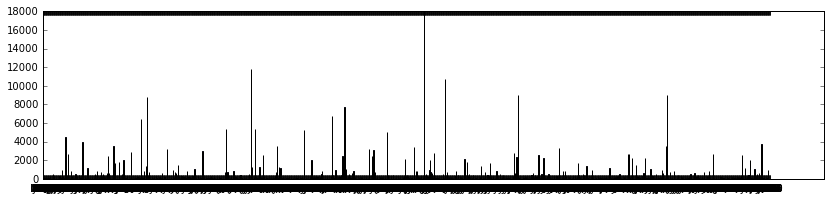

In [21]:
codes_, counts = zip(*counter_all_codes.items())
indices = np.arange(len(counts))

plt.figure(figsize=(14, 3))
plt.bar(sorted(indices), counts, 0.8)
plt.xticks(indices, codes_);

## Prepare test and train set

### Build new preprocessing classification instance 
Classification class will manage production of one hot vectors for classification

In [22]:
from Classification import *
classif_icd=ClassificationPreprocessing()
classif_icd.fit(prep_codes)

In [23]:
classif_icd.encoder.classes_

array(['A010', 'A021', 'A029', ..., 'Z993', 'Z998', 'Z999'], dtype=object)

In [24]:
from sklearn.model_selection import train_test_split
y_train, y_test, x_train, x_test = train_test_split(
    prep_codes, prep_sentences,test_size=25000, random_state=0)


#### Add the thesaurus sentences for learning

In [25]:
th_codes_=[]
th_base_sentences_=[]
for c,s in zip(th_codes,th_base_sentences):
    take=True
    for c_ in c:
        if c_ not in classif_icd.encoder.classes_:
            take=False
    if take:
        th_codes_.append(c)
        th_base_sentences_.append(tp.tokenizer(s))
            

In [26]:
x_train_=x_train+th_base_sentences_
y_train_=y_train+th_codes_

#### Vectorization of text and Onehot encoded target with new classification

In [161]:
MAX_SEQUENCE_LENGTH=40

x_train_def=fe.features_from_tokens(x_train_,MAX_SEQUENCE_LENGTH)
x_test_def=fe.features_from_tokens(x_test,MAX_SEQUENCE_LENGTH)

print('x_train shape=',str(x_train_def.shape))
print('x_test shape=',str(x_test_def.shape))

y_train_def=classif_icd.encoder.transform(y_train_)
y_test_def=classif_icd.encoder.transform(y_test)

print('y_train shape=',str(y_train_def.shape))
print('y_test shape=',str(y_test_def.shape))

x_train shape= (399412, 40)
x_test shape= (25000, 40)
y_train shape= (399412, 3259)
y_test shape= (25000, 3259)


In [28]:
##Empty target
len([c for c in y_train_def if np.sum(c)==0])

6955

## Conv1D RNN with embeddings

In [30]:
from keras.layers import Dense, Input, Flatten,concatenate
from keras.layers import GlobalAveragePooling1D, Embedding, Dropout
from keras.models import Model
from keras import optimizers
from keras.layers import Conv1D, MaxPooling1D, Flatten

model_name='MultipleConv1D_FullICD_clef_submission_model'

MAX_SEQUENCE_LENGTH=40
EMBEDDING_DIM = 512
N_CLASSES = len(classif_icd.encoder.classes_)
MAX_NB_WORDS = len(fe.dictionary)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)



# A 1D convolution with 128 output channels
x = Conv1D(128,5, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
# A 1D convolution with 64 output channels
x = Conv1D(64, 5, activation='relu')(x)
# MaxPool divides the length of the sequence by 5
x = Dropout(0.2)(x)
x = GlobalAveragePooling1D()(x)


# A 1D convolution with 128 output channels
y = Conv1D(128,7, activation='relu')(embedded_sequences)
y = MaxPooling1D(3)(y)
y = Dropout(0.2)(y)
# A 1D convolution with 64 output channels
y = Conv1D(64, 5, activation='relu')(y)
# MaxPool divides the length of the sequence by 5
y = Dropout(0.2)(y)
y = GlobalAveragePooling1D()(y)


# A 1D convolution with 128 output channels
z = Conv1D(128,9, activation='relu')(embedded_sequences)
z = MaxPooling1D(3)(z)
z = Dropout(0.2)(z)
# A 1D convolution with 64 output channels
z = Conv1D(64,5, activation='relu')(z)
# MaxPool divides the length of the sequence by 5
z = Dropout(0.2)(z)
z = GlobalAveragePooling1D()(z)


# merge
merged = concatenate([x,y,z])
# interpretation


predictions = Dense(N_CLASSES, activation='softmax')(merged)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 512)      10038272    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 36, 128)      327808      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 34, 128)      458880      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_5 (

#### Fit the model

In [ ]:
#history=model.fit(x_train_def,y_train_def,epochs=5,
#                  batch_size=32, shuffle=True,validation_split=0.2)

In [ ]:
#model.save('models/'+model_name+'.h5')

#### or load saved version

In [31]:
from keras.models import load_model
model = load_model('models/'+model_name+'.h5')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 512)      10038272    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 36, 128)      327808      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 34, 128)      458880      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_11 

In [162]:
y_pred=model.predict(x_test_def)

### Evaluation (in the new classification)

In [163]:
from Evaluation import *
ev=evaluation()

In [164]:
x_test[1]

['défaillance', 'multi', 'viscérale']

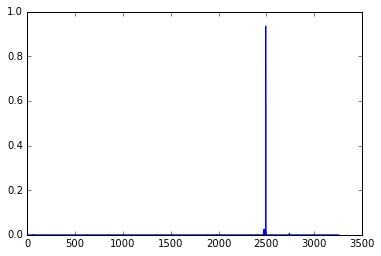

In [165]:
plt.plot(y_pred[1])
# 10 22

In [166]:
a=fe.features_from_tokens([['arythmie', 'complète', 'fibrillation', 'auriculaire','insuffisance','cardiaque']],MAX_SEQUENCE_LENGTH)
b=model.predict(a)
[classif_icd.encoder.classes_[k] for k,i in enumerate(ev.GetPredFromThreshold(b,0.1)[0]) if i==1 ]

['I489', 'I509']

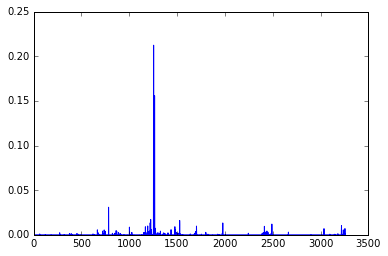

In [167]:
plt.plot(b[0])

In [38]:
Results= ev.prepare_results()
for t in [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.15,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01,0.001]:
    Results=Results.append(ev.GetMetricsFromHotEncoder(y_test_def,y_pred,t),ignore_index=True)
Results.to_csv('models/'+model_name+'.csv')
Results

,Threshold,Mean of pred codes,Mean of true codes,Mean of true positives,Mean of false positives,Mean of false negatives,Precision,Recall,F1-Score,F2-Score
0,0.900,0.5,1.2,0.0,0.0,0.7,97.7,40.0,56.7,45.3
1,0.800,0.6,1.2,1.0,0.0,0.6,96.9,49.3,65.3,54.6
2,0.700,0.7,1.2,1.0,0.0,0.6,96.0,55.0,70.0,60.2
3,0.600,0.8,1.2,1.0,0.0,0.5,95.3,58.7,72.7,63.6
4,0.500,0.8,1.2,1.0,0.0,0.5,94.4,62.1,75.0,66.7
5,0.400,0.9,1.2,1.0,0.1,0.4,93.2,66.1,77.3,70.2
6,0.300,0.9,1.2,1.0,0.1,0.4,91.2,69.8,79.0,73.2
7,0.200,1.1,1.2,1.0,0.2,0.3,85.8,74.7,79.9,76.7
8,0.150,1.2,1.2,1.0,0.2,0.3,82.0,77.4,79.6,78.3
9,0.100,1.3,1.2,1.0,0.3,0.2,76.2,80.3,78.2,79.4


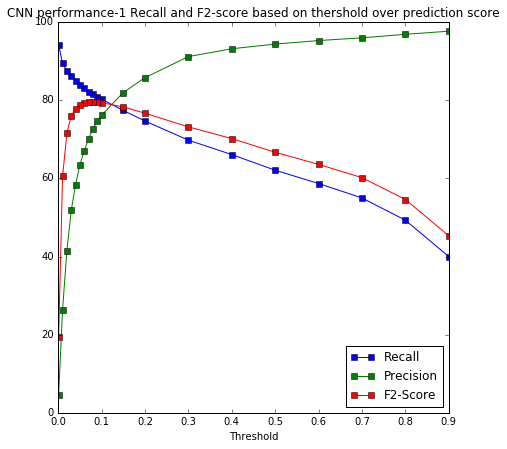

In [39]:
fig = plt.figure(1, figsize=(7, 7))
ax1=plt.subplot(1, 1, 1)

ax1.plot(Results['Threshold'], Results['Recall'], "s-",label='Recall')
ax1.plot(Results['Threshold'], Results['Precision'], "s-",label='Precision')
ax1.plot(Results['Threshold'], Results['F2-Score'], "s-",label='F2-Score')
ax1.set_xlabel("Threshold")
ax1.legend(loc="lower right")
ax1.set_title('CNN performance-1 Recall and F2-score based on thershold over prediction score')
fig.savefig('cnn_preformance-1.png')

### Detail of the prédiction a the code level

In [40]:
c_1000=[classif_icd.class_to_index[c] for c,n in counter_all_codes.items() if n>=1000]
c_500_1000=[classif_icd.class_to_index[c] for c,n in counter_all_codes.items()if  n>=500 and n<1000]
c_200_500=[classif_icd.class_to_index[c] for c,n in counter_all_codes.items() if  n>=200 and n<500]
c_200=[classif_icd.class_to_index[c] for c,n in counter_all_codes.items() if n<200]

In [41]:
pred=np.where(y_pred<0.15,-2,1)
res=pred+y_test_def

In [43]:
f_neg=Counter(np.nonzero(res==-1)[1])
f_pos=Counter(np.nonzero(res==1)[1])
t_pos=Counter(np.nonzero(res==2)[1])

In [44]:
nb=Counter(np.nonzero(y_test_def==1)[1])

#### proportion of true positves by group of codes frequencies

In [46]:
res={}
for i in range(classif_icd.n_classes):
    if i in nb:
        res[i]=t_pos[i]/nb[i]

In [47]:
g_1000_tp=np.mean(np.array([val for c,val in res.items() if c in c_1000]))
g_500_1000_tp=np.mean(np.array([val for c,val in res.items() if c in c_500_1000]))
c_200_500_tp=np.mean(np.array([val for c,val in res.items() if c in c_200_500]))
c_200_tp=np.mean(np.array([val for c,val in res.items() if c in c_200]))

#### proportion of true positves by group of codes frequencies

In [49]:
res={}
for i in range(classif_icd.n_classes):
    if i in nb:
        res[i]=f_neg[i]/nb[i]

In [50]:
g_1000_fn=np.mean(np.array([val for c,val in res.items() if c in c_1000]))
g_500_1000_fn=np.mean(np.array([val for c,val in res.items() if c in c_500_1000]))
c_200_500_fn=np.mean(np.array([val for c,val in res.items() if c in c_200_500]))
c_200_fn=np.mean(np.array([val for c,val in res.items() if c in c_200]))

In [149]:
print(
'\n Freq codes [1000 ; inf [  : Prop. true positives '+str(round(g_1000_tp*100,1))+' - Prop. false negatives '+str(round(g_1000_fn*100,1))+
'\n Freq codes [500 ; 1000 [  : Prop. true positives '+str(round(g_500_1000_tp*100,1))+' - Prop. false negatives '+str(round(g_500_1000_fn*100,1))+
'\n Freq codes [200 ; 5000 [  : Prop. true positives '+str(round(c_200_500_tp*100,1))+' - Prop. false negatives '+str(round(c_200_500_fn*100,1))+
'\n Freq codes [0 ; 200 [     : Prop. true positives '+str(round(c_200_tp*100,1))+'  -Prop. false negatives '+str(round(c_200_fn*100,1))
)


 Freq codes [1000 ; inf [  : Prop. true positives 84.4 - Prop. false negatives 15.6
 Freq codes [500 ; 1000 [  : Prop. true positives 75.0 - Prop. false negatives 25.0
 Freq codes [200 ; 5000 [  : Prop. true positives 67.7 - Prop. false negatives 32.3
 Freq codes [0 ; 200 [     : Prop. true positives 28.5  -Prop. false negatives 71.5


## Words (from thesaurus) appearance predictor

### due to weekness of predictor for codes with low frequencie, try improve prediction for those codes with word recognition on the ICD index.

In [52]:
_restriction_=c_200_500+c_200
len(_restriction_)

3126

### Use [word : ICD codes] indexes and reverse

In [56]:
from string import punctuation
pattern = r"[{}]".format(punctuation+'\s')

keyword_index_icd={}
sent_index_icd=[]
with open('dictionaries/CIM-10-GM AI FR A-Z CSV_2016_11_09_1810.csv', 'r', encoding="utf-8") as f:
    
    reader = csv.reader(f)
    
    next(reader)
    
    for line_ in reader:
        
        c=line_[1]
        c=re.sub(r'[\+\.\-†*!\s]','',c)
        c=re.split(',',c)
        
        s=line_[2]
        s=re.sub(r'[:]','',s)
        s=s.split(' ¬ ')
        
        for c_ in c:
            if c_ in classif_icd.encoder.classes_:
                keyword=re.sub(pattern,'',line_[0]).lower()

                if keyword not in keyword_index_icd:
                    keyword_index_icd[keyword]=set()

                keyword_index_icd[keyword].update([classif_icd.class_to_index[c_]])

### predictor based of singularity of word association x number of words recognize in a sentence

In [53]:
from random import uniform

In [199]:
def WordsAppearancePrediction(s):
    
    keyword_codes_array=np.zeros(classif_icd.n_classes)
    keyword_codes_array2=np.zeros(classif_icd.n_classes)
    keyword_codes_array3=np.zeros(classif_icd.n_classes)
    
    keyword_codes_array_=np.zeros(classif_icd.n_classes)
    for w in s:

        if w in keyword_index_icd:
            ind=[n for n in keyword_index_icd[w]]
            #keyword_codes_array[ind]=keyword_codes_array[ind]+uniform(0,1)
            keyword_codes_array[ind]+=1/len(keyword_index_icd[w])
            keyword_codes_array2[ind]+=1
    

    keyword_codes_array3[_restriction_]=keyword_codes_array[_restriction_]*keyword_codes_array2[_restriction_]
    
    keyword_codes_array_[np.argmax(keyword_codes_array2)]=0.10
    return keyword_codes_array_

In [200]:
a=['arythmie', 'complète', 'fibrillation', 'auriculaire','insuffisance','cardiaque']
[[v,classif_icd.encoder.classes_[k]] for k,v in enumerate(WordsAppearancePrediction(a)) if v!=0]

[[0.1, 'I489']]

#### Word recognition prediction will be added to 

In [201]:
wk_pred=np.array([WordsAppearancePrediction(s) for s in x_test])
y_pred_final=y_pred+wk_pred
Results= ev.prepare_results()
for t in [0.3,0.25,0.2,0.15,0.1,0.09,.08]:
    Results=Results.append(ev.GetMetricsFromHotEncoder(y_test_def,y_pred_final,t),ignore_index=True)

Results

,Threshold,Mean of pred codes,Mean of true codes,Mean of true positives,Mean of false positives,Mean of false negatives,Precision,Recall,F1-Score,F2-Score
0,0.30,1.0,1.2,1.0,0.1,0.4,91.1,70.1,79.2,73.5
1,0.25,1.0,1.2,1.0,0.1,0.3,89.6,72.2,80.0,75.2
2,0.20,1.1,1.2,1.0,0.2,0.3,85.6,75.0,80.0,76.9
3,0.15,1.2,1.2,1.0,0.2,0.3,81.6,77.7,79.6,78.5
4,0.10,2.0,1.2,1.0,1.0,0.2,51.3,81.2,62.8,72.7
5,0.09,2.2,1.2,1.0,1.2,0.2,46.5,81.8,59.3,71.0
6,0.08,2.2,1.2,1.0,1.2,0.2,45.8,82.4,58.9,71.1


In [196]:
pred=np.where(y_pred_final<0.15,-2,1)
res=pred+y_test_def

In [197]:
f_neg=Counter(np.nonzero(res==-1)[1])
f_pos=Counter(np.nonzero(res==1)[1])
t_pos=Counter(np.nonzero(res==2)[1])
res={}
for i in range(classif_icd.n_classes):
    if i in nb:
        res[i]=t_pos[i]/nb[i]
g_1000_tp=np.mean(np.array([val for c,val in res.items() if c in c_1000]))
g_500_1000_tp=np.mean(np.array([val for c,val in res.items() if c in c_500_1000]))
c_200_500_tp=np.mean(np.array([val for c,val in res.items() if c in c_200_500]))
c_200_tp=np.mean(np.array([val for c,val in res.items() if c in c_200]))
res={}
for i in range(classif_icd.n_classes):
    if i in nb:
        res[i]=f_neg[i]/nb[i]
g_1000_fn=np.mean(np.array([val for c,val in res.items() if c in c_1000]))
g_500_1000_fn=np.mean(np.array([val for c,val in res.items() if c in c_500_1000]))
c_200_500_fn=np.mean(np.array([val for c,val in res.items() if c in c_200_500]))
c_200_fn=np.mean(np.array([val for c,val in res.items() if c in c_200]))


In [198]:
print(
'\n Freq codes [1000 ; inf [  : Prop. true positives '+str(round(g_1000_tp*100,1))+' - Prop. false negatives '+str(round(g_1000_fn*100,1))+
'\n Freq codes [500 ; 1000 [  : Prop. true positives '+str(round(g_500_1000_tp*100,1))+' - Prop. false negatives '+str(round(g_500_1000_fn*100,1))+
'\n Freq codes [200 ; 5000 [  : Prop. true positives '+str(round(c_200_500_tp*100,1))+' - Prop. false negatives '+str(round(c_200_500_fn*100,1))+
'\n Freq codes [0 ; 200 [     : Prop. true positives '+str(round(c_200_tp*100,1))+'  -Prop. false negatives '+str(round(c_200_fn*100,1))
)


 Freq codes [1000 ; inf [  : Prop. true positives 85.3 - Prop. false negatives 14.7
 Freq codes [500 ; 1000 [  : Prop. true positives 76.0 - Prop. false negatives 24.0
 Freq codes [200 ; 5000 [  : Prop. true positives 68.5 - Prop. false negatives 31.5
 Freq codes [0 ; 200 [     : Prop. true positives 34.2  -Prop. false negatives 65.8


## Final prediction

### Build prediction function
Return a vector of possible codes from entity recognition in a sentence.

First :
- build a vector V of all possible ICD codes inialized at 0

Loop on words of a sentences (ie a document on the dataset):
- for each words of a sentence find an entry in the [word/code] index
- for each word get the codes associated if any
- for those codes add a random number in the vector V

At the end :
- build a table of frequencies of the numbers associated with each codes in V (resulting in addition of random numbers a each word step)
- only keep the codes that have a few reprensents in the table of frequencies (resulting of association of distinct words or presence of words associated with few codes)



In [193]:
def predictor_OneHotEncoded(x_test):
    
    ## Conv RNN
    x_test_def=fe.features_from_tokens(x_test,MAX_SEQUENCE_LENGTH)
    y_pred=model.predict(x_test_def)
    
    ## words recognition prediction
    wk_pred=np.array([WordsAppearancePrediction(s) for s in x_test])
    
    y_pred_final=y_pred+wk_pred

    return y_pred_final

def predictor(x_test,threshold=0.15):
    
    
    y_codes=[]
    
    ohe=predictor_OneHotEncoded(x_test)
  
    for v in ohe:
       
        y_codes.append([classif_icd.encoder.classes_[num] for num,c in enumerate(v) if c>=threshold])
        
    
    return y_codes

Test

In [194]:
a=[['arythmie', 'complète', 'fibrillation', 'auriculaire','insuffisance','cardiaque']]
predictor(a)

[['I489']]

In [132]:
y_pred_final=predictor_OneHotEncoded(x_test)
Results= ev.prepare_results()
for t in [0.3,0.25,0.2,0.15,0.1,0.09,.08]:
    Results=Results.append(ev.GetMetricsFromHotEncoder(y_test_def,y_pred_final,t),ignore_index=True)

Results

,Threshold,Mean of pred codes,Mean of true codes,Mean of true positives,Mean of false positives,Mean of false negatives,Precision,Recall,F1-Score,F2-Score
0,0.30,1.0,1.2,1.0,0.1,0.4,91.1,70.0,79.1,73.4
1,0.25,1.0,1.2,1.0,0.1,0.3,89.5,72.1,79.9,75.1
2,0.20,1.1,1.2,1.0,0.2,0.3,85.6,75.0,80.0,76.9
3,0.15,1.2,1.2,1.0,0.2,0.3,81.8,77.7,79.7,78.5
4,0.10,1.6,1.2,1.0,0.6,0.2,61.4,81.1,69.9,76.2
5,0.09,2.2,1.2,1.0,1.2,0.2,45.7,81.7,58.6,70.6
6,0.08,2.3,1.2,1.0,1.2,0.2,45.1,82.3,58.2,70.6


### Final performance on test set

In [133]:
ev.GetMetricsFromHotEncoder(y_test_def,predictor_OneHotEncoded(x_test),0.15)

{'F1-Score': 79.7,
 'F2-Score': 78.5,
 'Mean of false negatives': 0.3,
 'Mean of false positives': 0.2,
 'Mean of pred codes': 1.2,
 'Mean of true codes': 1.2,
 'Mean of true positives': 1.0,
 'Precision': 81.8,
 'Recall': 77.7,
 'Threshold': 0.15}

# Validation set

In [150]:
pc=punctuation.replace('-','')
## Composed words (separate by -) will be treat as 2 single words
th_base_tokens=[tp.simple_tokenizer(s,pc) for s in th_base_sentences]
w=set([w for s in th_base_tokens for w in s if re.search(r'-',w)
       and len(w)>3 
       and not re.search('[\s,.\+/^]',w)
       and w not in ['anti-corps']])

rev_comp_words={}
comp_words=[]
for w_ in w:
    nw=w_.replace('-','')
    if len(nw)>3:
        rev_comp_words[nw]= w_
        comp_words.append(w_.replace('-',''))

In [151]:
## fit preprocessing functions with cim 10 entries to build a reference dictionnary
th_base_tokens=[tp.simple_tokenizer(s) for s in th_base_sentences]
vocab, rev_vocab = build_vocabulary(th_base_tokens)

tp.comp_words=comp_words
tp.rev_comp_words=rev_comp_words
corrector_dict=[w for w in vocab]+comp_words # build a more complete dictionary for word recogntion and spelling correction
tp.fit_corrector(corrector_dict) 

### import and preprocessing

In [152]:
file='corpus/AlignedCauses_2015F_1.csv'
data=[]
sents=[]
with open(file, 'r', encoding="utf-8") as f:
    next(f)
    for line in f:
        line_=line.split(';')
        data.append(line_)
        s=tp.tokenizer(line_[6])
        sents.append(s)

#### Spelling corrections : all words that are not in vocabulary are candidate for automatic correction

In [153]:
train_vocab, rev_train_vocab = build_vocabulary([s for s in sents])
missing_words=[w for w in train_vocab if w not in vocab]

In [154]:
word_correction={}
non_corr=[]
for w in missing_words:
     
    w_=tp.best_correction(w)
    if w_!=w:
        word_correction[w]=w_
    else:
        non_corr.append(w)

####  Compound words that have been corrected (replacement and split)

In [155]:
x_validate_final=[]
for s in sents:
    
    ns=[]
    for w in s:
        
        if w in vocab:
            
            if w in comp_words:
                ns=ns+re.split('-',rev_comp_words[w])
            else:
                ns.append(w)
                
        else:
            
            if w in word_correction:
                
                w_=word_correction[w]
                
                if w_ in comp_words:
                    ns=ns+re.split('-',rev_comp_words[w_])
                else:
                    ns.append(w_)
                    
    x_validate_final.append(ns)

In [202]:
## Data for pre-training with CIM thesaurses model with cepidc codes

y_validate_pred=predictor(x_validate_final)

In [203]:
i=20
for x_,y_ in zip(x_validate_final[0:i],y_validate_pred[0:i]):
    print(' '.join(x_)+' : '+', '.join(y_))

démence type alzheimer stade sévère : G309
coma hépatique : K729
carcinome hépato cellulaire : C220
aeg hospitalisation psp : 
métastases hépatiques : C787
carcinome épidermoïde treponema origine vésical : C679
cancer os : 
adénocarcinome rectal multi métastatique : C20
arrêt respiratoire : R092
cancer bronchique : C349
métastases cérébrales : C793
métastases osseuses : C795
insuffisance respiratoire aigu : J960
pneumonie hypoxémiante : J189
syndrome dépressif sévère : F329
péritonite : K659
ulcer gastrique : K259
ains : 
patiente démente grabataire : F03, Z740
choc septique : A419, R572


In [204]:
with open('raw_run2.csv', 'w', encoding="utf-8") as f:
    writer = csv.writer(f,delimiter=';')
    writer.writerow( ('DocID','YearCoded','LineID','StandardText1','StandardText2','ICD10') )
   
    for d,pred_codes in zip(data,y_validate_pred):
        for c in pred_codes:
            writer.writerow( (d[0],
                              d[1],
                              d[2],
                              '',
                              '',
                              c)
                           )




In [205]:
with open('aligned_run2.csv', 'w', encoding="utf-8") as f:
    writer = csv.writer(f,delimiter=';')
    writer.writerow( ('DocID','YearCoded','Gender','Age','LocationOfDeath','LineID',
                      'RawText','IntType','IntValue',
                     'StandardText1','StandardText2','ICD10'))
    for d,pred_codes in zip(data,y_validate_pred):
        for c in pred_codes:
            writer.writerow( (d[0],
                              d[1],
                              d[2],
                              d[3],
                              d[4],
                              d[5],
                              d[6],
                              d[7],
                              d[8].replace('\n',''),
                              '',
                              '',
                              c) )
        